In [1]:
import numpy as np
import pandas as pd
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../scripts")
from utils import load_data
from tensorflow import keras
from scipy.stats import pearsonr, ttest_ind, ttest_1samp

import seaborn as sns
from sklearn.decomposition import PCA
import random
import scipy

In [2]:
np.random.seed(82)
NUM_RANDOM_SAMPLES = 10

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 0) & (moas_occurrence['moa1 occurrence'] > 0)& (moas_occurrence['moa2 occurrence'] > 0)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [5]:
def generate_latent_df(latent_df):
    moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
    meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,latent_df], axis=1)

    # fill negative control DMSO profiles, change the NaN MOA label to be DMSO
    meta_moa_latent_df.loc[meta_moa_latent_df['Metadata_broad_sample'] == 'DMSO', 'moa'] = 'DMSO'

    #drop profiles with NaN MOAs
    meta_moa_latent_df = meta_moa_latent_df.dropna(subset=['moa']).reset_index(drop = True)

    # add columns to the dataframe that are randomnly shuffled permutations of the MOA column
    for i in range(NUM_RANDOM_SAMPLES):
        random_moa_labels = meta_moa_latent_df[['moa']].sample(frac=1).reset_index(drop=True)    
        random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels' + str(i)})
        meta_moa_latent_df = pd.concat([random_moa_labels, meta_moa_latent_df], axis=1)
        
    return meta_moa_latent_df

In [6]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [7]:
def calculate_means(meta_moa_latent_df, columns):
    subset_means = []
    subset_random_means = []

    for pipe in valid_pipes:
        subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
        subset_mean = subset.groupby(['moa'])[columns].mean()

        subsets_random_mean = []
        for i in range(NUM_RANDOM_SAMPLES):
            moa_label = 'random_moa_labels' + str(i)
            subset_random = subset_by_moa(pipe, meta_moa_latent_df, moa_label)
            subset_random_mean = subset_random.groupby([moa_label])[columns].mean()
            subsets_random_mean.append(subset_random_mean)

        subset_means.append(subset_mean)

        subset_random_means.append(subsets_random_mean)
    
    return subset_means, subset_random_means

In [8]:
def calculate_dmso_means(meta_moa_latent_df, columns):
    DMSO = meta_moa_latent_df[meta_moa_latent_df.moa == 'DMSO']
    DMSO_means = np.mean(DMSO[columns])

    DMSO_means_random = []

    for i in range(NUM_RANDOM_SAMPLES):
        label = 'random_moa_labels' + str(i)
        DMSO_random = meta_moa_latent_df[meta_moa_latent_df[label] == 'DMSO']
        DMSO_means_random.append(np.mean(DMSO_random[columns]))
    return DMSO_means, DMSO_means_random

In [9]:
def generate_post_LSA_representations(subset_means, subset_random_means, DMSO_means, DMSO_means_random):
    representations_after_LSA = []
    representations_after_LSA_random = []

    for i in range(len(subset_means)):
        
        representation_after_LSA = LSA(subset_means[i].loc[valid_pipes[i].split("|")[0]],subset_means[i].loc[valid_pipes[i].split("|")[1]],DMSO_means)
        representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
        representations_after_LSA.append(representation_after_LSA)

        LSA_random_1pipe = []
        for j in range(NUM_RANDOM_SAMPLES):
            representation_after_LSA_random = LSA(subset_random_means[i][j].loc[valid_pipes[i].split("|")[0]],subset_random_means[i][j].loc[valid_pipes[i].split("|")[1]],DMSO_means_random[j])
            representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
            LSA_random_1pipe.append(representation_after_LSA_random)    

        representations_after_LSA_random.append(LSA_random_1pipe)

    
    return representations_after_LSA, representations_after_LSA_random

In [34]:
def decode_LSA_representations(representations_after_LSA, representations_after_LSA_random, model, decoder):
    predictions = []
    predictions_random = []
    print(model not in ['pca', 'complete'])
    print(model)
    for i in range(len(representations_after_LSA)):

        if model not in ['pca', 'complete']:
            prediction = decoder.predict(representations_after_LSA[i])
        elif model == 'pca':
            prediction = pca.inverse_transform(representations_after_LSA[i])
        elif model == 'complete':    
            prediction = representations_after_LSA[i].values.tolist()
        else:
            print('"model" must be "vae", "pca", or "complete"')
            
        predictions.append(pd.DataFrame(prediction))

        predictions_random_1pipe = []

        for j in range(NUM_RANDOM_SAMPLES):
            if model not in ['pca', 'complete']:
                prediction_random = decoder.predict(representations_after_LSA_random[i][j])
            elif model == 'pca':
                prediction_random = pca.inverse_transform(representations_after_LSA_random[i][j])
            elif model == 'complete':
                prediction_random = representations_after_LSA_random[i][j].values.tolist()
            else:
                print('"model" must be "vae", "pca", or "complete"')

            predictions_random_1pipe.append(prediction_random)


        predictions_random.append(predictions_random_1pipe)

    predictions = np.array(predictions)
    predictions_random = np.array(predictions_random)
    
    return predictions, predictions_random

In [11]:
# calculates all L2 distances for both per MOA combo and general distribution comparison for all MOA combos
def calculate_L2_distances(predictions, predictions_random):
    mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_FormFactor':]
    L2 = []
    L2_random = []
    moa_similarity = []
    per_moa_zscore = []
    
    mean = complete_features_df.mean()
    for i in range(len(predictions)):
        desired_moa = np.array(mean_of_moas[(mean_of_moas.index == valid_pipes[i])])
        moa_similarity.append(np.linalg.norm(desired_moa[0] - mean))
        L2_distance = np.linalg.norm(predictions[i]-desired_moa[0])
        L2.append(L2_distance)
        
        L2_random_per_moa = []
        for j in range(NUM_RANDOM_SAMPLES):
            L2_distance_random = np.linalg.norm(predictions_random[i][j][0]-desired_moa[0])
            L2_random_per_moa.append(L2_distance_random)

        L2_random += L2_random_per_moa

        zscore = scipy.stats.zscore(L2_random_per_moa + [L2_distance])[-1]
        per_moa_zscore.append(zscore)

    return L2, L2_random, moa_similarity, per_moa_zscore

In [12]:
per_moa_performance_df = pd.DataFrame({"MOA":valid_pipes,"vae zscore":per_moa_zscore_vae,"pca zscore":per_moa_zscore_pca, "moa similarity":moa_similarity})

NameError: name 'per_moa_zscore_vae' is not defined

In [28]:
per_moa_performance_df

,MOA,vae zscore,pca zscore,moa similarity
0,NFkB pathway inhibitor|proteasome inhibitor,-3.152561,-2.894573,5.111749
1,dopamine receptor antagonist|serotonin recepto...,0.700629,-0.367246,0.507123
2,cyclooxygenase inhibitor|prostanoid receptor a...,1.271352,0.183029,0.515390
3,mTOR inhibitor|PI3K inhibitor,-3.110497,-2.865672,2.238932
4,insulin sensitizer|PPAR receptor agonist,-0.379198,-0.421259,0.609560
...,...,...,...,...
79,SRC inhibitor|tubulin polymerization inhibitor,-3.045737,-2.541317,4.022180
80,adrenergic receptor agonist|imidazoline recept...,-0.134483,1.440974,0.816092
81,SRC inhibitor|VEGFR inhibitor,-0.016884,1.307236,1.384400
82,acetylcholinesterase inhibitor|monoamine oxida...,-1.454282,-2.116090,1.560094


In [29]:
per_moa_performance_df = per_moa_performance_df.sort_values('vae zscore')
# per_moa_performance_df.to_csv('level5_beta_moa_performance.csv')

In [30]:
well_predicted = per_moa_performance_df[per_moa_performance_df['vae zscore'] < 0]
well_predicted

,MOA,vae zscore,pca zscore,moa similarity
0,NFkB pathway inhibitor|proteasome inhibitor,-3.152561,-2.894573,5.111749
17,microtubule inhibitor|tubulin polymerization i...,-3.144751,-2.992890,5.388521
3,mTOR inhibitor|PI3K inhibitor,-3.110497,-2.865672,2.238932
58,Aurora kinase inhibitor|JAK inhibitor,-3.100413,-3.090174,5.080567
46,DNA inhibitor|topoisomerase inhibitor,-3.090222,-3.046192,3.116495
79,SRC inhibitor|tubulin polymerization inhibitor,-3.045737,-2.541317,4.022180
60,EGFR inhibitor|VEGFR inhibitor,-2.927428,1.502708,1.212173
18,DNA alkylating agent|DNA synthesis inhibitor,-2.650289,-2.530400,3.704015
51,glucocorticoid receptor agonist|immunosuppressant,-2.612471,-2.903659,2.007021
56,RNA synthesis inhibitor|topoisomerase inhibitor,-2.411932,-2.518478,3.580546


In [31]:
sns.set_theme()

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'A|B distance to mean Cell Painting feature values')

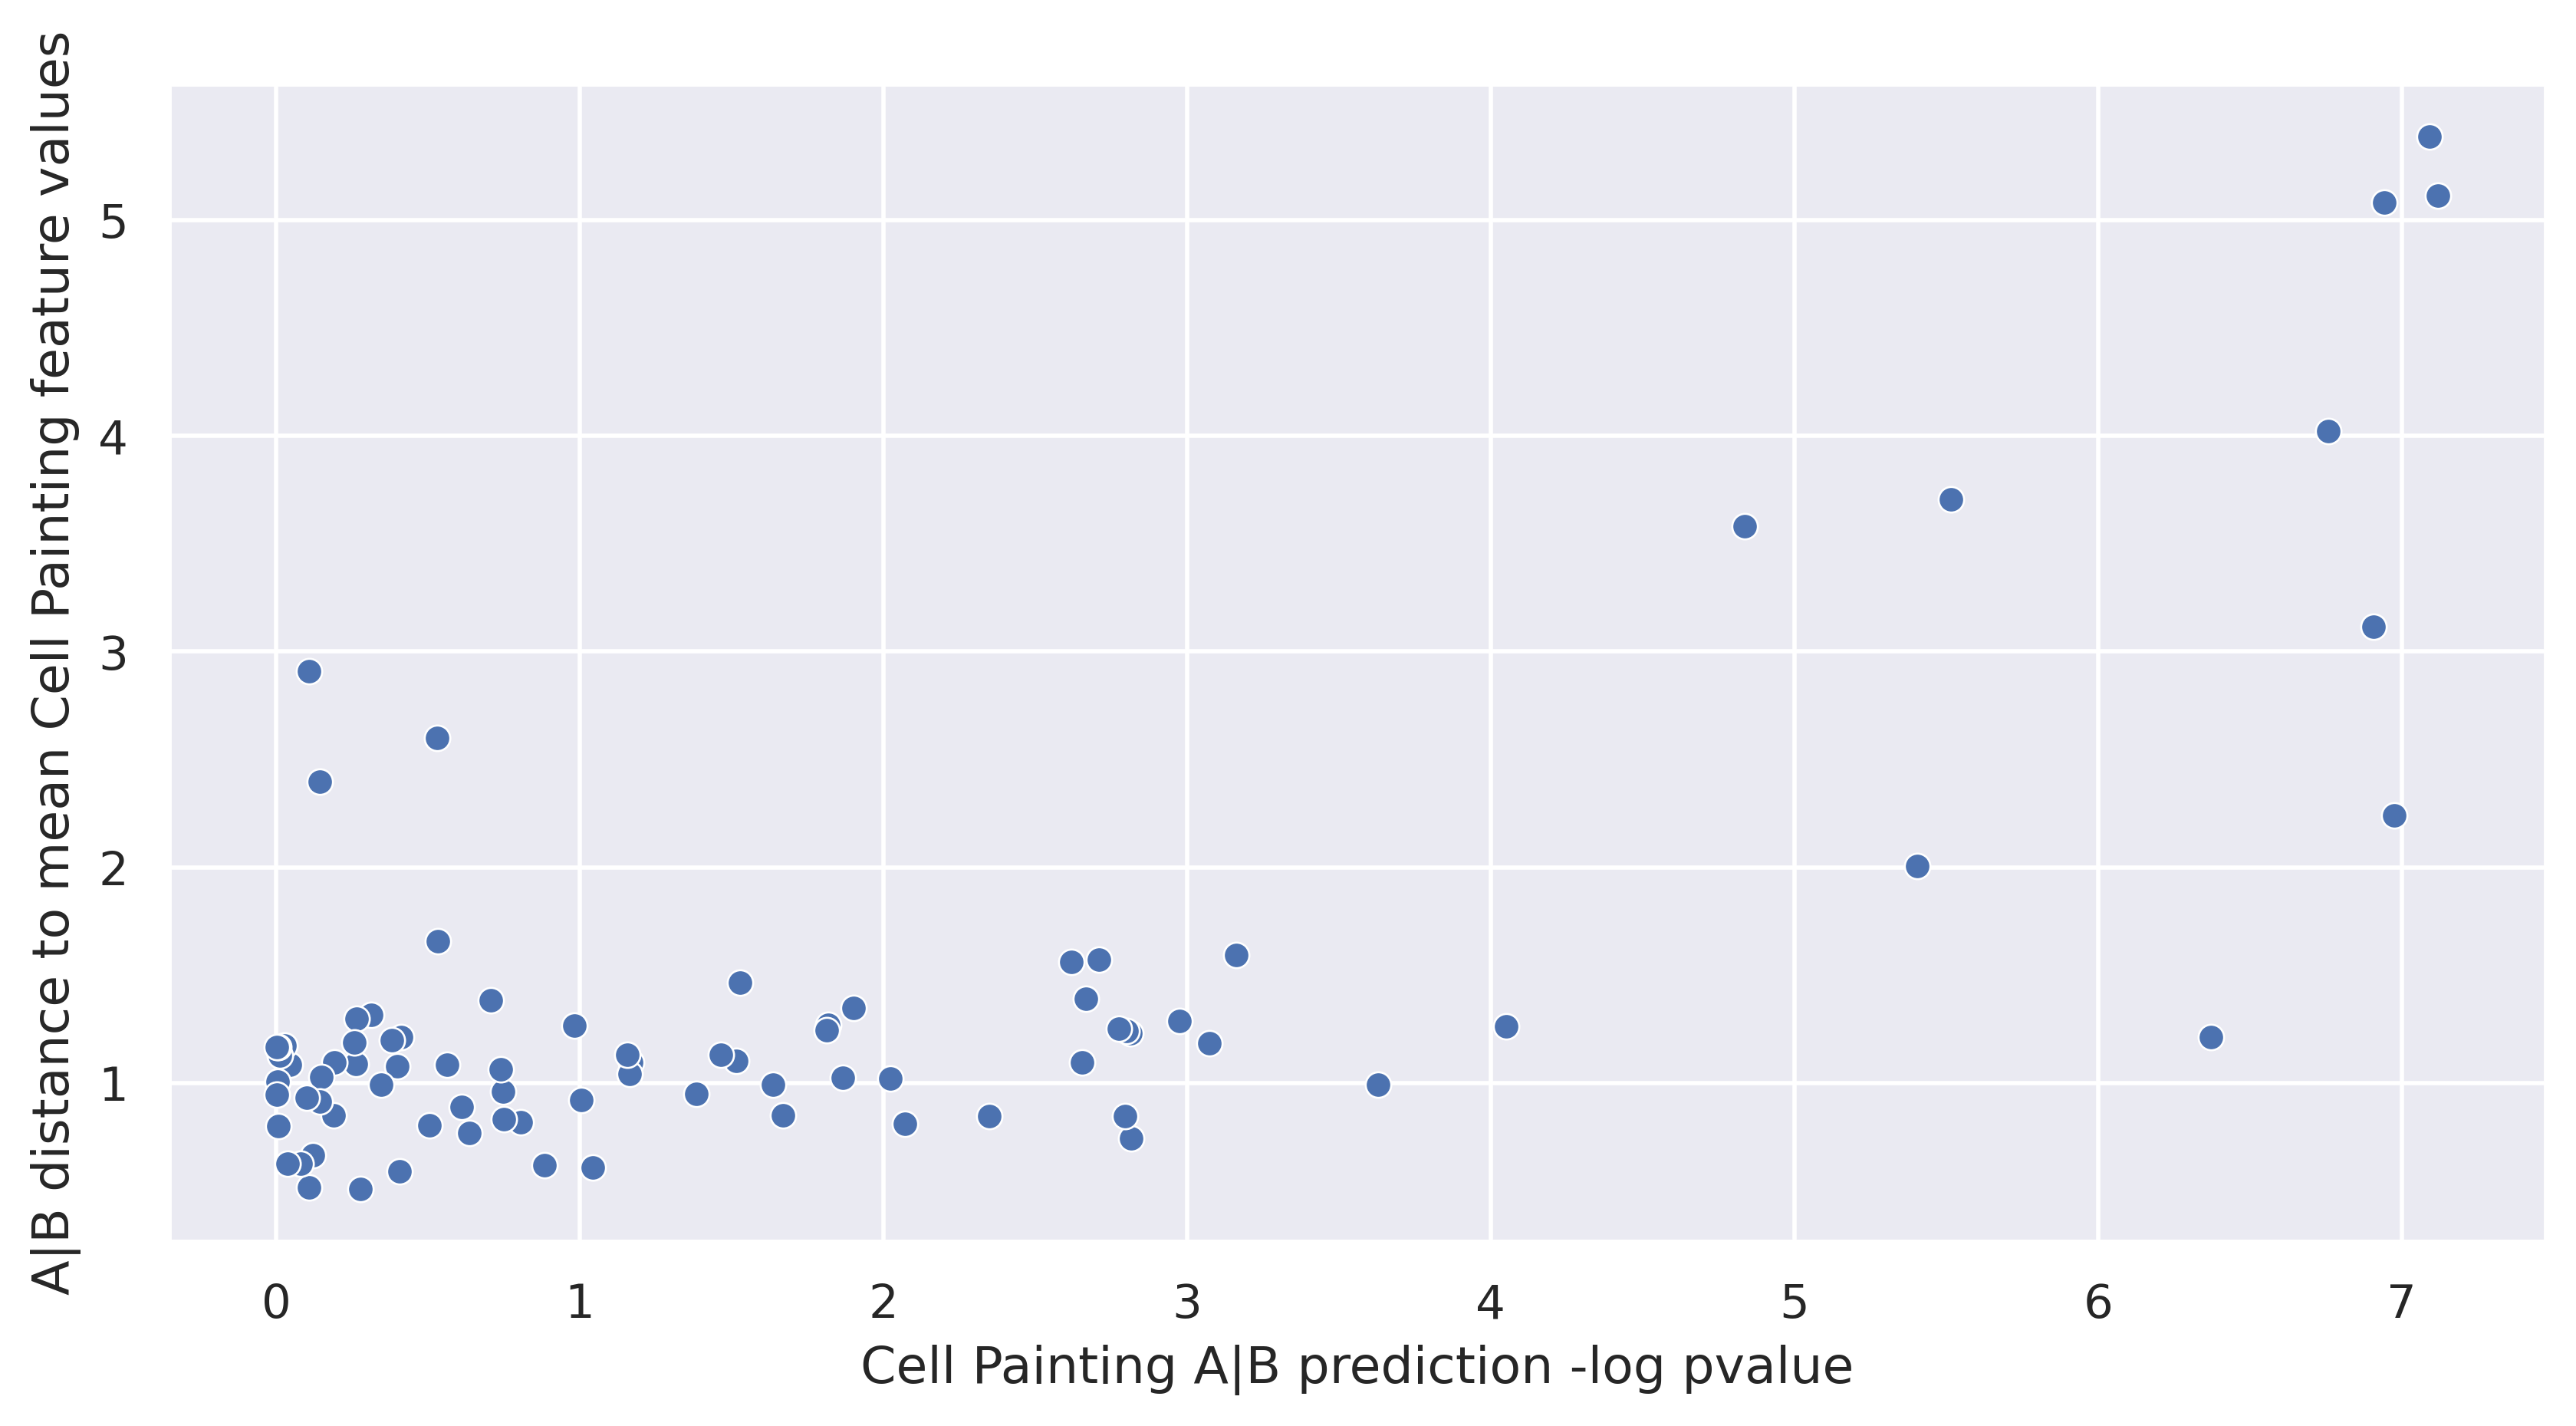

In [32]:
# per_moa_performance_df['vae pvalue'] = per_moa_performance_df['vae pvalue']/2
# per_moa_performance_df.loc[per_moa_performance_df['vae tstat'] > 0, 'vae pvalue'] = 1 - per_moa_performance_df['vae pvalue']
# per_moa_performance_df['vae pvalue']  = - np.log(per_moa_performance_df['vae pvalue'])


fig, ax = plt.subplots(figsize=(10, 5), dpi = 400)
sns.scatterplot(- np.log(scipy.stats.norm.sf(-(per_moa_performance_df['vae zscore']))), per_moa_performance_df['moa similarity'])
plt.xlabel("Cell Painting A|B prediction -log pvalue")
plt.ylabel("A|B distance to mean Cell Painting feature values")

In [35]:
L2_df = pd.DataFrame(L2_vae, columns = ['VAE Unshuffled'])
L2_random_df = pd.DataFrame(L2_vae_random, columns = ['VAE Shuffled'])
L2_pca_df = pd.DataFrame(L2_pca, columns = ['PCA Unshuffled'])
L2_pca_random_df = pd.DataFrame(L2_pca_random, columns = ['PCA Shuffled'])
L2_complete_df = pd.DataFrame(L2_complete, columns = ['Complete Unshuffled'])
L2_complete_random_df = pd.DataFrame(L2_complete_random, columns = ['Complete Shuffled'])
L2_df = pd.concat([L2_df, L2_random_df, L2_pca_df, L2_pca_random_df, L2_complete_df, L2_complete_random_df], ignore_index = True, axis = 1)
L2_df.columns = ['VAE Unshuffled','VAE Shuffled','PCA Unshuffled','PCA Shuffled','Complete Unshuffled','Complete Shuffled']
# L2_df.to_csv('L2_general.tsv', sep = '\t')

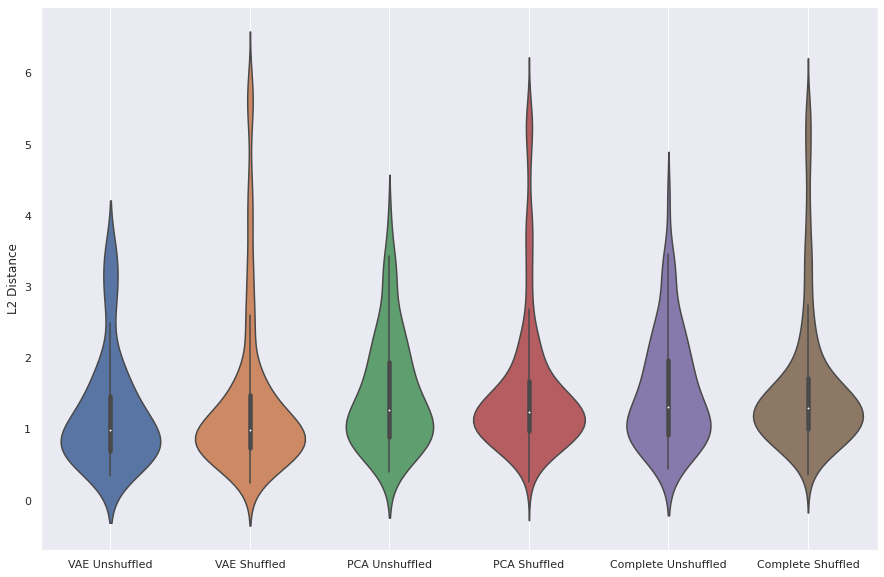

In [36]:
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.grid()

plt.show()

In [37]:
L2_df.describe()

,VAE Unshuffled,VAE Shuffled,PCA Unshuffled,PCA Shuffled,Complete Unshuffled,Complete Shuffled
count,84.000000,840.000000,84.000000,840.000000,84.000000,840.000000
mean,1.246043,1.377747,1.501850,1.563792,1.547711,1.595201
std,0.804601,1.158267,0.782634,1.021845,0.795365,1.006587
min,0.345175,0.245087,0.398678,0.250422,0.441434,0.350258
25%,0.691806,0.730056,0.881700,0.969830,0.914178,1.004309
50%,0.978387,0.977925,1.264196,1.243726,1.309384,1.293056
75%,1.460773,1.478745,1.945271,1.672450,1.961255,1.710305
max,3.545097,5.978802,3.923328,5.686756,4.234526,5.683079


In [38]:
# computing a 2-tailed 2-sample t-test. In the paper, we compute the one-tailed p-value by dividing the follwing p-value by 2
print(ttest_ind(L2_df['VAE Unshuffled'].dropna(), L2_df['VAE Shuffled']))
print(ttest_ind(L2_df['PCA Unshuffled'].dropna(), L2_df['PCA Shuffled']))
print(ttest_ind(L2_df['Complete Unshuffled'].dropna(), L2_df['Complete Shuffled']))
#1.29
#1.51

Ttest_indResult(statistic=-1.0176398352457259, pvalue=0.3091161045865388)
Ttest_indResult(statistic=-0.5398601112788896, pvalue=0.5894238684424189)
Ttest_indResult(statistic=-0.41943307510170325, pvalue=0.6749973620546992)


In [20]:
latent_dim = 10
latent_space_columns = np.arange(0,latent_dim)
latent_space_columns = [str(latent_space_column) for latent_space_column in latent_space_columns]

In [21]:
latent_names = ["","_vanilla","_mmd","_leaveOut","_vanilla_leaveOut","_mmd_leaveOut","pca","complete"]

In [22]:
latent_dfs = {}
for latent_name in latent_names:
    if latent_name == "pca":
        pca = PCA(n_components=latent_dim)
        latent_dfs[latent_name] = pd.DataFrame(pca.fit_transform(complete_features_df), columns = latent_space_columns)
    elif latent_name == "complete":
        latent_dfs[latent_name] = complete_features_df
    else:
        latent_dfs[latent_name] = pd.read_csv(f"level5Latent{latent_name}.csv").drop("Unnamed: 0", axis = 1)

In [35]:
for latent_name in latent_dfs:
    meta_moa_latent_df = generate_latent_df(latent_dfs[latent_name])
    subset_means, subset_random_means = calculate_means(meta_moa_latent_df, latent_space_columns)
    DMSO_means, DMSO_means_random  = calculate_dmso_means(meta_moa_latent_df, latent_space_columns)
    representations_after_LSA, representations_after_LSA_random = generate_post_LSA_representations(subset_means, subset_random_means, DMSO_means, DMSO_means_random)
    decoder = None
    if latent_name not in ['pca', 'complete']:
        decoder = keras.models.load_model(f"../2.train/models/level5Decoder{latent_name}")        
    predictions, predictions_random = decode_LSA_representations(representations_after_LSA, representations_after_LSA_random, latent_name, decoder)
    L2, L2_random, moa_similarity, per_moa_zscore = calculate_L2_distances(predictions, predictions_random)

    

True

True
_vanilla
True
_mmd
True
_leaveOut
True
_vanilla_leaveOut
True
_mmd_leaveOut
False
pca


KeyError: "Columns not found: '3', '8', '6', '9', '2', '7', '4', '5', '0', '1'"

In [ ]:
meta_moa_vae_latent_df = generate_latent_df(vae_latent_df)
meta_moa_pca_latent_df = generate_latent_df(pca_latent_df)
meta_moa_complete_df = generate_latent_df(complete_features_df)

In [ ]:
subset_vae_means, subset_vae_random_means = calculate_means(meta_moa_vae_latent_df, latent_space_columns)
subset_pca_means, subset_pca_random_means = calculate_means(meta_moa_pca_latent_df, latent_space_columns)
subset_complete_means, subset_complete_random_means = calculate_means(meta_moa_complete_df, complete_features_df.columns)

In [ ]:
DMSO_vae_means, DMSO_vae_means_random  = calculate_dmso_means(meta_moa_vae_latent_df, latent_space_columns)
DMSO_pca_means, DMSO_pca_means_random = calculate_dmso_means(meta_moa_pca_latent_df, latent_space_columns)
DMSO_complete_means, DMSO_complete_means_random = calculate_dmso_means(meta_moa_complete_df, complete_features_df.columns)

In [ ]:
representations_after_LSA_vae, representations_after_LSA_vae_random = generate_post_LSA_representations(subset_vae_means, subset_vae_random_means, DMSO_vae_means, DMSO_vae_means_random)
representations_after_LSA_pca, representations_after_LSA_pca_random = generate_post_LSA_representations(subset_pca_means, subset_pca_random_means, DMSO_pca_means, DMSO_pca_means_random)
representations_after_LSA_complete, representations_after_LSA_complete_random = generate_post_LSA_representations(subset_complete_means, subset_complete_random_means, DMSO_complete_means, DMSO_complete_means_random)

In [ ]:
decoder = keras.models.load_model("../2.train/models/level5Decoder")

In [ ]:
L2_vae, L2_vae_random, moa_similarity, per_moa_zscore_vae = calculate_L2_distances(predictions_vae, predictions_vae_random)
L2_pca, L2_pca_random, moa_similarity, per_moa_zscore_pca = calculate_L2_distances(predictions_pca, predictions_pca_random)
L2_complete, L2_complete_random, moa_similarity, per_moa_zscore_complete = calculate_L2_distances(predictions_complete, predictions_complete_random)